In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0 , x_test/255.0
x_train, x_test = x_train.reshape(-1,784), x_test.reshape(-1,784)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (60000, 784)
x_test:  (10000, 784)
y_train:  (60000, 1)
y_test:  (10000, 1)


In [16]:
generator_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 256, input_dim = 138, activation = 'relu'),
    tf.keras.layers.Dense(units = 784, activation = 'sigmoid')
])

noise = tf.keras.layers.Input(shape = (128,))
label = tf.keras.layers.Input(shape = (1,))
label_onehot = tf.keras.layers.CategoryEncoding(10, output_mode='one_hot')(label)

model_input = tf.keras.layers.concatenate([noise, label_onehot], axis = 1)
generated_image = generator_model(model_input)

generator = tf.keras.models.Model([noise, label], generated_image)

In [17]:
discriminator_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 256,input_dim = 794, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

input_image = tf.keras.layers.Input(shape = (784,))
label = tf.keras.layers.Input(shape = (1,))
label_onehot = tf.keras.layers.CategoryEncoding(10, output_mode='one_hot')(label)

model_input = tf.keras.layers.concatenate([input_image, label_onehot], axis = 1)
validity = discriminator_model(model_input)

discriminator = tf.keras.models.Model([input_image, label], validity)

In [18]:
optim_d = tf.keras.optimizers.Adam(learning_rate = 0.0002)

discriminator.compile(loss = ['binary_crossentropy'], 
                      optimizer = optim_d)

In [19]:
noise = tf.keras.layers.Input(shape = (128,))
label = tf.keras.layers.Input(shape = (1,))
generated_image = generator([noise, label])
discriminator.trainable = False
validity = discriminator([generated_image, label])

combined = tf.keras.models.Model([noise, label], validity)

In [20]:
optim_combined = tf.keras.optimizers.Adam(learning_rate = 0.0002)

combined.compile(loss = ['binary_crossentropy'], 
                 optimizer = optim_combined)

In [21]:
def create_noise(samples):
    return np.random.normal(0, 1, [samples, 128])

def plot_generated_images(generator):

    noise = create_noise(10)
    label = np.arange(0, 10).reshape(-1, 1)

    generated_images = generator.predict([noise, label])

    plt.figure(figsize = (90, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i].reshape((28, 28)), 'gray', interpolation = 'nearest')
        plt.title('Digit: {}'.format(i), fontsize = 75)
        plt.axis('off')
    plt.show()

4/4 [==============================] - 0s 2ms/step
Discriminator Loss:  0.11860702186822891
Generator Loss:  3.573744535446167
1/1 [==============================] - 0s 15ms/step


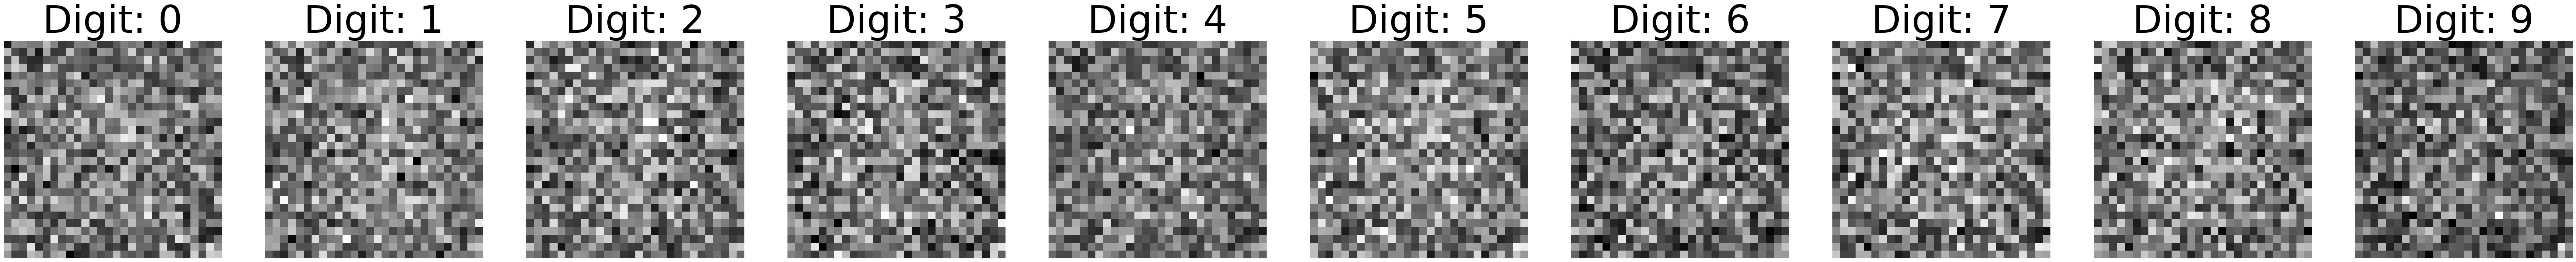

4/4 [==============================] - 0s 3ms/step
Discriminator Loss:  0.024613041896373034
Generator Loss:  5.083578109741211
1/1 [==============================] - 0s 25ms/step


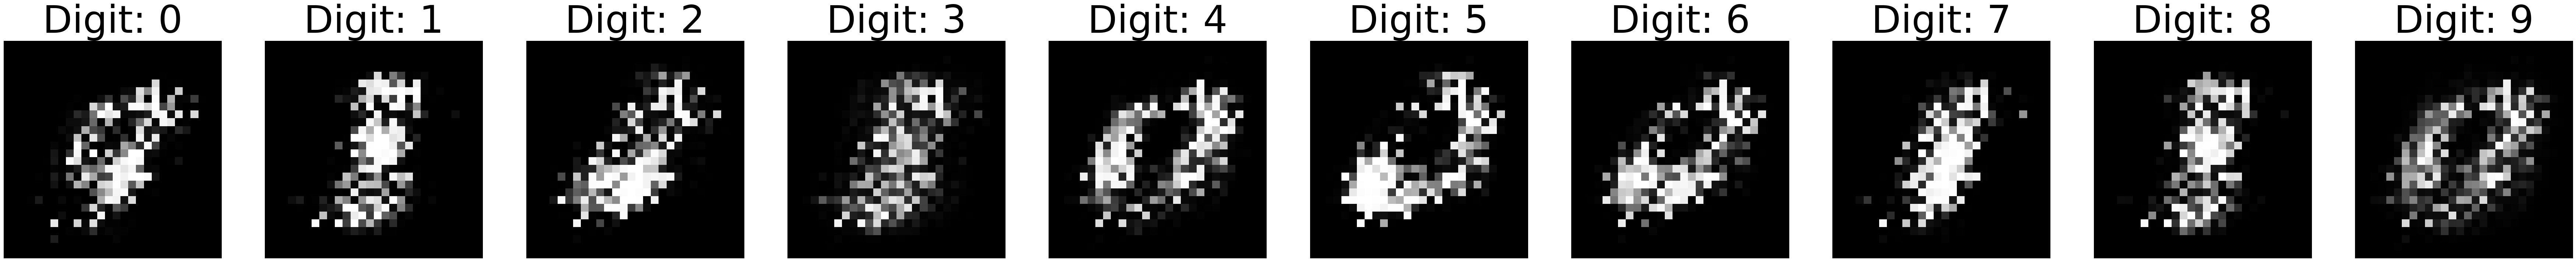

4/4 [==============================] - 0s 7ms/step


In [23]:
n_iter = 10000
batch_size = 100

valid = np.ones(batch_size)
fake = np.zeros(batch_size)
for i in range(n_iter):
        
    # Train Discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images, labels = x_train[idx], y_train[idx]
    
    noise = create_noise(batch_size)
    generated_images = generator.predict([noise,labels])
    
    d_loss_real = discriminator.train_on_batch([real_images, labels], valid)
    d_loss_fake = discriminator.train_on_batch([generated_images, labels], fake)
    d_loss = d_loss_real + d_loss_fake
    
    # Train Generator
    noise= create_noise(batch_size)
    labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    g_loss = combined.train_on_batch([noise, labels], valid)
    
    if i % 5000 == 0:

        print('Discriminator Loss: ', d_loss)
        print('Generator Loss: ', g_loss)

        plot_generated_images(generator)